# Preparation

## Load Libraries

In [1104]:
%%capture
!pip install fredapi

In [1105]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from fredapi import Fred as fred
import time

from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

## Country Name & Country Code


United States: USA, US  
United Kingdom: GBR, GB  
Canada: CAN, CA  
Germany: DEU, DE  
Japan: JPN, JP



In [1106]:
# Country Code
country = 'United States'
cc_recession = 'USA'
cc_stock = 'US'

# Series id
if country == 'United States':
  recession_id = 'USREC'
else:
  recession_id = cc_recession + 'RECM'

# Stock id
stock_id = 'SPASTT01' + cc_stock + 'M661N'

## Fred API Modification

If we use UK data, We need to modify FRED class because some indicators starts from 1200-01-01, which is out of bounds of Pandas' timestamps. Please refer this URL: https://github.com/mortada/fredapi/issues/27

In [1107]:
# @title
# Fred API class

import os
import sys
import xml.etree.ElementTree as ET
if sys.version_info[0] >= 3:
    import urllib.request as url_request
    import urllib.parse as url_parse
    import urllib.error as url_error
else:
    import urllib2 as url_request
    import urllib as url_parse
    import urllib2 as url_error

import pandas as pd

urlopen = url_request.urlopen
quote_plus = url_parse.quote_plus
urlencode = url_parse.urlencode
HTTPError = url_error.HTTPError


class Fred:
    earliest_realtime_start = '1776-07-04'
    latest_realtime_end = '9999-12-31'
    nan_char = '.'
    max_results_per_request = 1000
    root_url = 'https://api.stlouisfed.org/fred'

    def __init__(self,
                 api_key=None,
                 api_key_file=None):
        """
        Initialize the Fred class that provides useful functions to query the Fred dataset. You need to specify a valid
        API key in one of 3 ways: pass the string via api_key, or set api_key_file to a file with the api key in the
        first line, or set the environment variable 'FRED_API_KEY' to the value of your api key. You can sign up for a
        free api key on the Fred website at http://research.stlouisfed.org/fred2/
        """
        self.api_key = None
        if api_key is not None:
            self.api_key = api_key
        elif api_key_file is not None:
            f = open(api_key_file, 'r')
            self.api_key = f.readline().strip()
            f.close()
        else:
            self.api_key = os.environ.get('FRED_API_KEY')

        if self.api_key is None:
            import textwrap
            raise ValueError(textwrap.dedent("""\
                    You need to set a valid API key. You can set it in 3 ways:
                    pass the string with api_key, or set api_key_file to a
                    file with the api key in the first line, or set the
                    environment variable 'FRED_API_KEY' to the value of your
                    api key. You can sign up for a free api key on the Fred
                    website at http://research.stlouisfed.org/fred2/"""))

    def __fetch_data(self, url):
        """
        helper function for fetching data given a request URL
        """
        url += '&api_key=' + self.api_key
        try:
            response = urlopen(url)
            root = ET.fromstring(response.read())
        except HTTPError as exc:
            root = ET.fromstring(exc.read())
            raise ValueError(root.get('message'))
        return root

    def _check_date_format(self, date_str):
        datetime = date_str.split('-')
        year = datetime[0]
        if (float(year[1]) < 7) and (float(year[1]) > 0):
            year = list(year)
            year[1] = '9'
        year = ''.join(year)
        datetime = [year,datetime[1],datetime[2]]
        datetime = '-'.join(datetime)
        return datetime

    def _parse(self, date_str, format='%Y-%m-%d'):
        """
        helper function for parsing FRED date string into datetime
        """
        try:
            rv = pd.to_datetime(date_str, format=format)
        except:
            date_str = self._check_date_format(date_str)
            rv = pd.to_datetime(date_str, format=format)
        if hasattr(rv, 'to_pydatetime'):
            rv = rv.to_pydatetime()
        return rv

    def get_series_info(self, series_id):
        """
        Get information about a series such as its title, frequency, observation start/end dates, units, notes, etc.

        Parameters
        ----------
        series_id : str
            Fred series id such as 'CPIAUCSL'

        Returns
        -------
        info : Series
            a pandas Series containing information about the Fred series
        """
        url = "%s/series?series_id=%s" % (self.root_url, series_id)
        root = self.__fetch_data(url)
        if root is None or not len(root):
            raise ValueError('No info exists for series id: ' + series_id)
        info = pd.Series(list(root)[0].attrib)
        return info

    def get_series(self, series_id, observation_start=None, observation_end=None, **kwargs):
        """
        Get data for a Fred series id. This fetches the latest known data, and is equivalent to get_series_latest_release()

        Parameters
        ----------
        series_id : str
            Fred series id such as 'CPIAUCSL'
        observation_start : datetime or datetime-like str such as '7/1/2014', optional
            earliest observation date
        observation_end : datetime or datetime-like str such as '7/1/2014', optional
            latest observation date
        kwargs : additional parameters
            Any additional parameters supported by FRED. You can see https://api.stlouisfed.org/docs/fred/series_observations.html for the full list

        Returns
        -------
        data : Series
            a Series where each index is the observation date and the value is the data for the Fred series
        """
        url = "%s/series/observations?series_id=%s" % (self.root_url, series_id)
        if observation_start is not None:
            observation_start = pd.to_datetime(observation_start,
                                               errors='raise')
            url += '&observation_start=' + observation_start.strftime('%Y-%m-%d')
        if observation_end is not None:
            observation_end = pd.to_datetime(observation_end, errors='raise')
            url += '&observation_end=' + observation_end.strftime('%Y-%m-%d')
        if kwargs.keys():
            url += '&' + urlencode(kwargs)
        root = self.__fetch_data(url)
        if root is None:
            raise ValueError('No data exists for series id: ' + series_id)
        data = {}
        for child in root:
            val = child.get('value')
            if val == self.nan_char:
                val = float('NaN')
            else:
                val = float(val)
            data[self._parse(child.get('date'))] = val
        return pd.Series(data)

    def get_series_latest_release(self, series_id):
        """
        Get data for a Fred series id. This fetches the latest known data, and is equivalent to get_series()

        Parameters
        ----------
        series_id : str
            Fred series id such as 'CPIAUCSL'

        Returns
        -------
        info : Series
            a Series where each index is the observation date and the value is the data for the Fred series
        """
        return self.get_series(series_id)

    def get_series_first_release(self, series_id):
        """
        Get first-release data for a Fred series id. This ignores any revision to the data series. For instance,
        The US GDP for Q1 2014 was first released to be 17149.6, and then later revised to 17101.3, and 17016.0.
        This will ignore revisions after the first release.

        Parameters
        ----------
        series_id : str
            Fred series id such as 'GDP'

        Returns
        -------
        data : Series
            a Series where each index is the observation date and the value is the data for the Fred series
        """
        df = self.get_series_all_releases(series_id)
        first_release = df.groupby('date').head(1)
        data = first_release.set_index('date')['value']
        return data

    def get_series_as_of_date(self, series_id, as_of_date):
        """
        Get latest data for a Fred series id as known on a particular date. This includes any revision to the data series
        before or on as_of_date, but ignores any revision on dates after as_of_date.

        Parameters
        ----------
        series_id : str
            Fred series id such as 'GDP'
        as_of_date : datetime, or datetime-like str such as '10/25/2014'
            Include data revisions on or before this date, and ignore revisions afterwards

        Returns
        -------
        data : Series
            a Series where each index is the observation date and the value is the data for the Fred series
        """
        as_of_date = pd.to_datetime(as_of_date)
        df = self.get_series_all_releases(series_id)
        data = df[df['realtime_start'] <= as_of_date]
        return data

    def get_series_all_releases(self, series_id, realtime_start=None, realtime_end=None):
        """
        Get all data for a Fred series id including first releases and all revisions. This returns a DataFrame
        with three columns: 'date', 'realtime_start', and 'value'. For instance, the US GDP for Q4 2013 was first released
        to be 17102.5 on 2014-01-30, and then revised to 17080.7 on 2014-02-28, and then revised to 17089.6 on
        2014-03-27. You will therefore get three rows with the same 'date' (observation date) of 2013-10-01 but three
        different 'realtime_start' of 2014-01-30, 2014-02-28, and 2014-03-27 with corresponding 'value' of 17102.5, 17080.7
        and 17089.6

        Parameters
        ----------
        series_id : str
            Fred series id such as 'GDP'
        realtime_start : str, optional
            specifies the realtime_start value used in the query, defaults to the earliest possible start date allowed by Fred
        realtime_end : str, optional
            specifies the realtime_end value used in the query, defaults to the latest possible end date allowed by Fred

        Returns
        -------
        data : DataFrame
            a DataFrame with columns 'date', 'realtime_start' and 'value' where 'date' is the observation period and 'realtime_start'
            is when the corresponding value (either first release or revision) is reported.
        """
        if realtime_start is None:
            realtime_start = self.earliest_realtime_start
        if realtime_end is None:
            realtime_end = self.latest_realtime_end
        url = "%s/series/observations?series_id=%s&realtime_start=%s&realtime_end=%s" % (self.root_url,
                                                                                         series_id,
                                                                                         realtime_start,
                                                                                         realtime_end)
        root = self.__fetch_data(url)
        if root is None:
            raise ValueError('No data exists for series id: ' + series_id)
        data = {}
        i = 0
        for child in root:
            val = child.get('value')
            if val == self.nan_char:
                val = float('NaN')
            else:
                val = float(val)
            realtime_start = self._parse(child.get('realtime_start'))
            # realtime_end = self._parse(child.get('realtime_end'))
            date = self._parse(child.get('date'))

            data[i] = {'realtime_start': realtime_start,
                       # 'realtime_end': realtime_end,
                       'date': date,
                       'value': val}
            i += 1
        data = pd.DataFrame(data).T
        return data

    def get_series_vintage_dates(self, series_id):
        """
        Get a list of vintage dates for a series. Vintage dates are the dates in history when a
        series' data values were revised or new data values were released.

        Parameters
        ----------
        series_id : str
            Fred series id such as 'CPIAUCSL'

        Returns
        -------
        dates : list
            list of vintage dates
        """
        url = "%s/series/vintagedates?series_id=%s" % (self.root_url, series_id)
        root = self.__fetch_data(url)
        if root is None:
            raise ValueError('No vintage date exists for series id: ' + series_id)
        dates = []
        for child in root:
            dates.append(self._parse(child.text))
        return dates

    def __do_series_search(self, url):
        """
        helper function for making one HTTP request for data, and parsing the returned results into a DataFrame
        """
        root = self.__fetch_data(url)

        series_ids = []
        data = {}

        num_results_returned = 0  # number of results returned in this HTTP request
        num_results_total = int(root.get('count'))  # total number of results, this can be larger than number of results returned
        for child in root:
            num_results_returned += 1
            series_id = child.get('id')
            series_ids.append(series_id)
            data[series_id] = {"id": series_id}
            fields = ["realtime_start", "realtime_end", "title", "observation_start", "observation_end",
                      "frequency", "frequency_short", "units", "units_short", "seasonal_adjustment",
                      "seasonal_adjustment_short", "last_updated", "popularity", "notes"]
            for field in fields:
                data[series_id][field] = child.get(field)

        if num_results_returned > 0:
            data = pd.DataFrame(data, columns=series_ids).T
            # parse datetime columns
            for field in ["realtime_start", "realtime_end", "observation_start", "observation_end", "last_updated"]:
                data[field] = data[field].apply(self._parse, format=None)
            # set index name
            data.index.name = 'series id'
        else:
            data = None
        return data, num_results_total

    def __get_search_results(self, url, limit, order_by, sort_order, filter):
        """
        helper function for getting search results up to specified limit on the number of results. The Fred HTTP API
        truncates to 1000 results per request, so this may issue multiple HTTP requests to obtain more available data.
        """

        order_by_options = ['search_rank', 'series_id', 'title', 'units', 'frequency',
                            'seasonal_adjustment', 'realtime_start', 'realtime_end', 'last_updated',
                            'observation_start', 'observation_end', 'popularity']
        if order_by is not None:
            if order_by in order_by_options:
                url = url + '&order_by=' + order_by
            else:
                raise ValueError('%s is not in the valid list of order_by options: %s' % (order_by, str(order_by_options)))

        if filter is not None:
            if len(filter) == 2:
                url = url + '&filter_variable=%s&filter_value=%s' % (filter[0], filter[1])
            else:
                raise ValueError('Filter should be a 2 item tuple like (filter_variable, filter_value)')

        sort_order_options = ['asc', 'desc']
        if sort_order is not None:
            if sort_order in sort_order_options:
                url = url + '&sort_order=' + sort_order
            else:
                raise ValueError('%s is not in the valid list of sort_order options: %s' % (sort_order, str(sort_order_options)))

        data, num_results_total = self.__do_series_search(url)
        if data is None:
            return data

        if limit == 0:
            max_results_needed = num_results_total
        else:
            max_results_needed = limit

        if max_results_needed > self.max_results_per_request:
            for i in range(1, max_results_needed // self.max_results_per_request + 1):
                offset = i * self.max_results_per_request
                next_data, _ = self.__do_series_search(url + '&offset=' + str(offset))
                data = pd.concat([data, next_data])
        return data.head(max_results_needed)

    def search(self, text, limit=1000, order_by=None, sort_order=None, filter=None):
        """
        Do a fulltext search for series in the Fred dataset. Returns information about matching series in a DataFrame.

        Parameters
        ----------
        text : str
            text to do fulltext search on, e.g., 'Real GDP'
        limit : int, optional
            limit the number of results to this value. If limit is 0, it means fetching all results without limit.
        order_by : str, optional
            order the results by a criterion. Valid options are 'search_rank', 'series_id', 'title', 'units', 'frequency',
            'seasonal_adjustment', 'realtime_start', 'realtime_end', 'last_updated', 'observation_start', 'observation_end',
            'popularity'
        sort_order : str, optional
            sort the results by ascending or descending order. Valid options are 'asc' or 'desc'
        filter : tuple, optional
            filters the results. Expects a tuple like (filter_variable, filter_value).
            Valid filter_variable values are 'frequency', 'units', and 'seasonal_adjustment'

        Returns
        -------
        info : DataFrame
            a DataFrame containing information about the matching Fred series
        """
        url = "%s/series/search?search_text=%s&" % (self.root_url,
                                                    quote_plus(text))
        info = self.__get_search_results(url, limit, order_by, sort_order, filter)
        return info

    def search_by_release(self, release_id, limit=0, order_by=None, sort_order=None, filter=None):
        """
        Search for series that belongs to a release id. Returns information about matching series in a DataFrame.

        Parameters
        ----------
        release_id : int
            release id, e.g., 151
        limit : int, optional
            limit the number of results to this value. If limit is 0, it means fetching all results without limit.
        order_by : str, optional
            order the results by a criterion. Valid options are 'search_rank', 'series_id', 'title', 'units', 'frequency',
            'seasonal_adjustment', 'realtime_start', 'realtime_end', 'last_updated', 'observation_start', 'observation_end',
            'popularity'
        sort_order : str, optional
            sort the results by ascending or descending order. Valid options are 'asc' or 'desc'
        filter : tuple, optional
            filters the results. Expects a tuple like (filter_variable, filter_value).
            Valid filter_variable values are 'frequency', 'units', and 'seasonal_adjustment'

        Returns
        -------
        info : DataFrame
            a DataFrame containing information about the matching Fred series
        """
        url = "%s/release/series?release_id=%d" % (self.root_url, release_id)
        info = self.__get_search_results(url, limit, order_by, sort_order, filter)
        if info is None:
            raise ValueError('No series exists for release id: ' + str(release_id))
        return info

    def search_by_category(self, category_id, limit=0, order_by=None, sort_order=None, filter=None):
        """
        Search for series that belongs to a category id. Returns information about matching series in a DataFrame.

        Parameters
        ----------
        category_id : int
            category id, e.g., 32145
        limit : int, optional
            limit the number of results to this value. If limit is 0, it means fetching all results without limit.
        order_by : str, optional
            order the results by a criterion. Valid options are 'search_rank', 'series_id', 'title', 'units', 'frequency',
            'seasonal_adjustment', 'realtime_start', 'realtime_end', 'last_updated', 'observation_start', 'observation_end',
            'popularity'
        sort_order : str, optional
            sort the results by ascending or descending order. Valid options are 'asc' or 'desc'
        filter : tuple, optional
            filters the results. Expects a tuple like (filter_variable, filter_value).
            Valid filter_variable values are 'frequency', 'units', and 'seasonal_adjustment'

        Returns
        -------
        info : DataFrame
            a DataFrame containing information about the matching Fred series
        """
        url = "%s/category/series?category_id=%d&" % (self.root_url,
                                                      category_id)
        info = self.__get_search_results(url, limit, order_by, sort_order, filter)
        if info is None:
            raise ValueError('No series exists for category id: ' + str(category_id))
        return info

In [1108]:
api_key='1c9b36f821931d47af2a923286a83447'
fred = Fred(api_key=api_key)

## Load IDs

In [1109]:
# Load the ids
data = pd.read_csv('ids_new.csv')
data

,id,title,realtime_start,realtime_end,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity
0,A038RC1,"Compensation of Employees, Received: Supplemen...",2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-01-26 09:20:32-06:00,7
1,A041RC1,Proprietors' income with inventory valuation a...,2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-01-26 09:20:30-06:00,11
2,A045RC1,Proprietors' income with inventory valuation a...,2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-01-26 09:20:34-06:00,5
3,A048RC1,Rental income of persons with capital consumpt...,2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-01-26 09:20:28-06:00,11
4,A061RC1,"Contributions for government social insurance,...",2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-01-26 09:20:32-06:00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,XTEXVA01USM667S,International Trade: Exports: Value (Goods): T...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,"US Dollar, Monthly level","US $, Monthly level",Seasonally Adjusted,SA,2024-01-12 14:12:05-06:00,18
658,XTIMVA01USM664N,International Trade: Imports: Value (Goods): T...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,"US Dollar, Monthly level","US $, Monthly level",Not Seasonally Adjusted,NSA,2024-01-12 14:22:22-06:00,3
659,XTIMVA01USM664S,International Trade: Imports: Value (Goods): T...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,"US Dollar, Monthly level","US $, Monthly level",Seasonally Adjusted,SA,2024-01-12 14:22:22-06:00,3
660,XTIMVA01USM667S,International Trade: Imports: Value (Goods): T...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,"US Dollar, Monthly level","US $, Monthly level",Seasonally Adjusted,SA,2024-01-12 14:12:07-06:00,12


## Download Time-Series Data

In [1110]:
def get_data_in_batches(data, batch_size=10, delay_seconds=5):
    """
    Get data for multiple series IDs in batches from the FRED API.

    Parameters:
      data: dataframe contains series IDs
      batch_size (int): The size of each batch.
      delay_seconds (int): The delay in seconds between batches.

    Returns:
      DataFrame: time-series data for all series IDs.
    """

    series_ids = data['id'].unique().tolist()

    data_dict = {}
    for i in range(0, len(series_ids), batch_size):
        batch_ids = series_ids[i:i + batch_size]

        # Make batch request to the FRED API
        batch_data = {series_id: fred.get_series(series_id) for series_id in batch_ids}

        data_dict.update(batch_data)

        time.sleep(delay_seconds)

    df = pd.DataFrame(data_dict)
    return df

In [1111]:
# Get time-series data

start_time = time.time()

df = get_data_in_batches(data, batch_size=10, delay_seconds=5)

print(f'Download completed in {round((time.time() - start_time) / 60, 2)} minutes.')
print(f'nubmer of indicators: ', df.shape[1])
print(f'number of months: ', df.shape[0])
display(df)

Download completed in 9.91 minutes.
nubmer of indicators:  662
number of months:  2041


,A038RC1,A041RC1,A045RC1,A048RC1,A061RC1,A063RC1,A068RC1,A132RC1,A229RC0,A229RX0,...,WPUID61113,WPUID6112,WPUID612,WPUID62,WPUSI012011,XTEXVA01USM667S,XTIMVA01USM664N,XTIMVA01USM664S,XTIMVA01USM667S,XTNTVA01USM667S
1854-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1112]:
# Save the dataset
df.to_csv(f'dataset_{country}_curated.csv')

In [1113]:
# visualize missing data
def check_missing_data(df):
  '''
  Visualizes missing data
  Rows with missing data are displayed in light blue
  '''
  plt.figure(figsize=(15,3))
  sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap ='tab20');

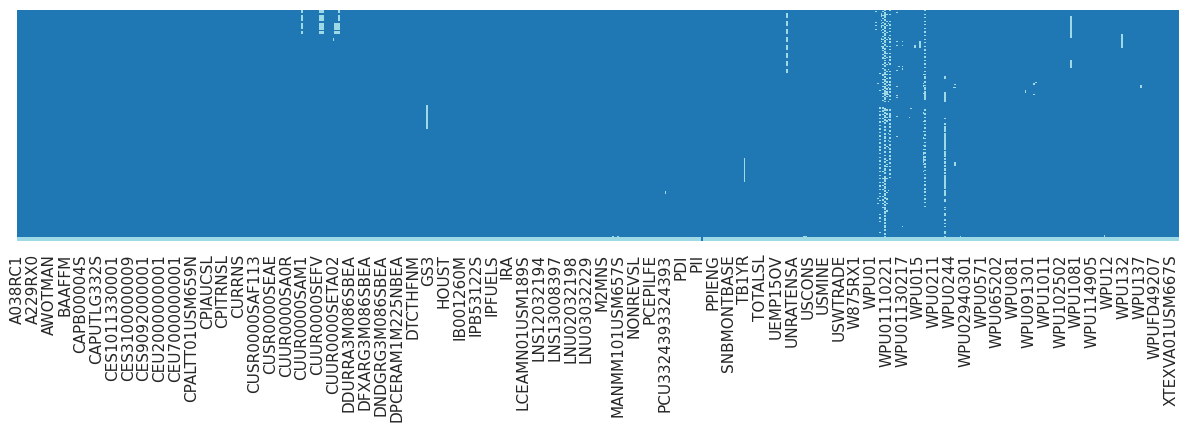

In [1114]:
check_missing_data(df[df.index>'1960-01-01'])

# EDA

In [1115]:
df = pd.read_csv(f'dataset_{country}_curated.csv', index_col=0, parse_dates=True)
df

,A038RC1,A041RC1,A045RC1,A048RC1,A061RC1,A063RC1,A068RC1,A132RC1,A229RC0,A229RX0,...,WPUID61113,WPUID6112,WPUID612,WPUID62,WPUSI012011,XTEXVA01USM667S,XTIMVA01USM664N,XTIMVA01USM664S,XTIMVA01USM667S,XTNTVA01USM667S
1854-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1116]:
# Set start & end date
start_date = '1960-01-01'
end_date = '2024-02-01'
df = df[(df.index >= start_date) & (df.index < end_date)]
df

,A038RC1,A041RC1,A045RC1,A048RC1,A061RC1,A063RC1,A068RC1,A132RC1,A229RC0,A229RX0,...,WPUID61113,WPUID6112,WPUID612,WPUID62,WPUSI012011,XTEXVA01USM667S,XTIMVA01USM664N,XTIMVA01USM664S,XTIMVA01USM667S,XTNTVA01USM667S
1960-01-01,27.8,50.0,40.4,16.2,16.4,23.1,330.3,222.8,2073.0,13441.0,...,30.600,34.400,33.100,30.400,33.800,1.534500e+09,1.178000e+09,1.246600e+09,1.246600e+09,2.879000e+08
1960-02-01,28.0,49.7,40.1,16.2,16.4,23.2,332.1,223.1,2070.0,13413.0,...,30.600,34.400,33.000,30.500,33.700,1.554400e+09,1.334000e+09,1.352800e+09,1.352800e+09,2.016000e+08
1960-03-01,28.1,49.5,39.8,16.2,16.4,23.7,336.9,223.2,2070.0,13400.0,...,30.500,34.300,33.000,31.000,33.700,1.540900e+09,1.415000e+09,1.291000e+09,1.291000e+09,2.499000e+08
1960-04-01,28.2,50.5,40.1,16.4,16.5,23.8,343.4,224.6,2081.0,13425.0,...,30.600,34.300,32.900,31.000,33.600,1.627400e+09,1.300000e+09,1.353100e+09,1.353100e+09,2.743000e+08
1960-05-01,28.3,50.8,40.2,16.4,16.4,23.9,337.0,225.0,2084.0,13429.0,...,30.500,34.000,32.900,30.900,33.500,1.644400e+09,1.293000e+09,1.278200e+09,1.278200e+09,3.662000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,2459.4,1877.8,1830.6,981.5,1820.7,3977.7,19600.9,10177.5,60719.0,50071.0,...,278.203,187.986,352.315,256.153,332.092,1.738100e+11,2.613060e+11,2.606370e+11,2.606370e+11,-8.682700e+10
2023-10-01,2466.4,1881.5,1836.4,984.7,1824.0,3979.3,19606.3,10189.6,60895.0,50202.0,...,273.733,188.057,351.444,251.359,328.803,1.712400e+11,2.768320e+11,2.609060e+11,2.609060e+11,-8.966600e+10
2023-11-01,2476.2,1889.8,1846.9,986.9,1833.1,3960.2,19680.2,10245.7,61114.0,50417.0,...,271.850,188.126,351.666,246.603,326.994,1.656790e+11,2.559760e+11,2.550100e+11,2.550100e+11,-8.933100e+10
2023-12-01,2484.8,1888.9,1848.1,989.2,1839.7,3962.5,19815.0,10280.5,61242.0,50438.0,...,275.011,188.630,352.272,237.827,328.905,NaN,NaN,NaN,NaN,NaN


### Definition
**Recession** = In general, a period of temporary economic decline during which trade and industrial activity are reduced, generally identified by **a fall in GDP in two successive quarters**.  

**Regime** = Regime refers to a condition of economic state, where 'Normal time' is represented as 0.0 and 'Recession' as 1.0.

**Leading Indictors**: Leading indicators are economic indicators that change before the economy starts to follow a particular pattern or trend. These indicators are used to predict future trends in the economy. Leading indicators typically include data points such as capacity utilization, business sentiment, and housing starts. Leading indicators are critical features for this project.

In [1117]:
# Rename columns
df.rename(columns={recession_id: 'Regime'}, inplace=True)
df.rename(columns={stock_id: 'Stock Price'}, inplace=True)

In [1118]:
# Create a subset for EDA
df_chart = df[['Stock Price', 'Regime']].dropna(axis=0)
df_chart

,Stock Price,Regime
1960-01-01,3.418156,0.0
1960-02-01,3.255919,0.0
1960-03-01,3.205570,0.0
1960-04-01,3.233542,0.0
1960-05-01,3.205570,1.0
...,...,...
2023-08-01,149.673393,0.0
2023-09-01,147.984189,0.0
2023-10-01,141.885220,0.0
2023-11-01,146.659218,0.0


In [1119]:
def get_recession_periods(df):
  '''
  Returns the first and last months of the recessionary period.
  ----------
  Parameters
  ----------
  df : data frame with stock price and regime indicator (recession: 1, normal: 0)
  '''
  dates = [] # List to store recessionary periods
  recession = 1
  normal = 0

  regime = normal
  for i, j, k in zip(df.Regime, df.index, range(len(df))):
    if i == recession and regime == normal: # Check if regime changes from normal to recession
      regime_span = [] # Create a new span for the recessionary period
      regime = recession
      regime_span.append(j) # Record the start date of the recession
    if i == normal and regime == recession: # Check if regime changes from recession to normal
      regime = normal
      regime_span.append(df.index[k-1]) # Record the end date of the recession
      dates.append(regime_span) # Add the recessionary period to the list of dates
    if i == recession and j == df.index[-1]: # Check if the last observation is part of a recession
      regime_span.append(j) # Record the end date of the recession
  return dates

In [1120]:
recession_periods = get_recession_periods(df_chart)
for i in recession_periods:
  print(i)

[Timestamp('1960-05-01 00:00:00'), Timestamp('1961-02-01 00:00:00')]
[Timestamp('1970-01-01 00:00:00'), Timestamp('1970-11-01 00:00:00')]
[Timestamp('1973-12-01 00:00:00'), Timestamp('1975-03-01 00:00:00')]
[Timestamp('1980-02-01 00:00:00'), Timestamp('1980-07-01 00:00:00')]
[Timestamp('1981-08-01 00:00:00'), Timestamp('1982-11-01 00:00:00')]
[Timestamp('1990-08-01 00:00:00'), Timestamp('1991-03-01 00:00:00')]
[Timestamp('2001-04-01 00:00:00'), Timestamp('2001-11-01 00:00:00')]
[Timestamp('2008-01-01 00:00:00'), Timestamp('2009-06-01 00:00:00')]
[Timestamp('2020-03-01 00:00:00'), Timestamp('2020-04-01 00:00:00')]


### Recession vs Stock Price

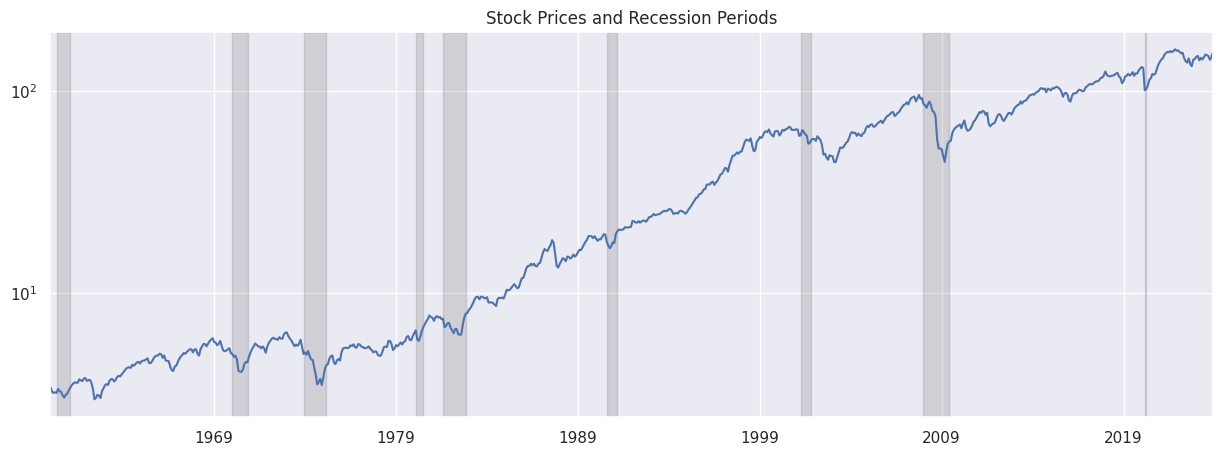

In [1121]:
# Plot Stock Chart & Recession Periods

plt.figure(figsize=(15,5))
df_chart['Stock Price'].plot(legend = False)
for i in range(len(recession_periods)):
  plt.axvspan(xmin = recession_periods[i][0], xmax = recession_periods[i][1], alpha = 0.25, color = 'grey')
plt.yscale('log')
plt.title('Stock Prices and Recession Periods');

### Recession vs Critical Indicator

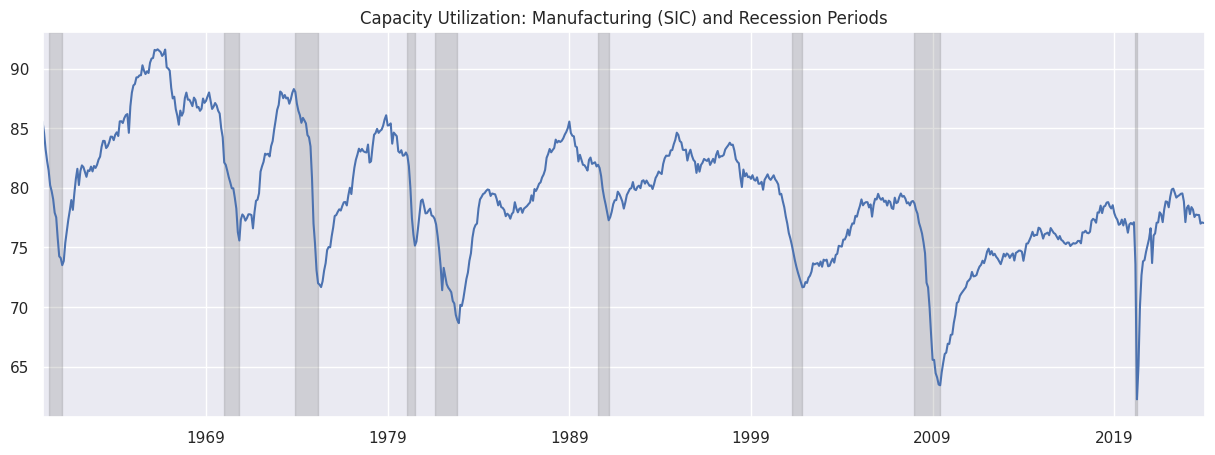

In [1122]:
# Capacity Utilization & Recession Periods
series_id = 'CUMFNS'
series_name = 'Capacity Utilization: Manufacturing (SIC)'
df[series_id].plot(legend=False, figsize=(15,5))
for i in range(len(recession_periods)):
  plt.axvspan(xmin = recession_periods[i][0], xmax = recession_periods[i][1], alpha = 0.25, color = 'grey')
plt.title(f'{series_name} and Recession Periods');

# Data Clearning

I changed n=10 to n=13, allowing deletion of indicators with more than 12 NAs. Additionally, I modified the code using vecorization to avoid a for loop.

In [1123]:
# # Slowest- don't use for large dataset
# def remove_variables(df, n=13):
#   '''
#   Removes a variable if it has more than "n" NaN values
#   Returns a dataframe without variables with NaNs
#   ----------
#   Parameters
#   ----------
#   df : dataframe
#   n : number of NaN values (int)
#   '''
#   dropped_cols = {}
#   for col in df.columns:
#     nas = df[col].isna().sum()
#     if nas > n:
#       dropped_cols[col] = nas
#       df.drop(col, axis=1, inplace=True)
#   return df, dropped_cols


# # Fastest: Avoid for loop and use vectorized version (but no NA counts)
# def remove_variables(df, n=13):
#     '''
#     Removes a variable if it has more than "n" NaN values
#     Returns a dataframe without variables with NaNs
#     ----------
#     Parameters
#     ----------
#     df : dataframe
#     n : number of NaN values (int)
#     '''
#     dropped_cols = df.columns[df.isna().sum() > n].tolist()
#     df = df.drop(columns=dropped_cols)
#     return df, dropped_cols


# 2nd fastest: use vectorization with NA counts
def remove_variables(df, n=13):
    '''
    Removes a variable if it has more than "n" NaN values
    Returns a dataframe without variables with NaNs
    ----------
    Parameters
    ----------
    df : dataframe
    n : number of NaN values (int)
    '''
    na_counts = df.isna().sum()
    dropped_cols = {col: count for col, count in na_counts.items() if count > n}

    df = df.drop(columns=list(dropped_cols.keys()))

    return df, dropped_cols


In [1124]:
# Remove all recession indicators to prevent information leakage
columns_to_drop = data[data['title'].str.contains('Recession Indicator', case=False)]['id'].tolist()
columns_to_drop.remove(recession_id)
print('columns to drop: ', columns_to_drop)

df = df.drop(columns=columns_to_drop)
df

columns to drop:  ['USRECM', 'USRECP']


,A038RC1,A041RC1,A045RC1,A048RC1,A061RC1,A063RC1,A068RC1,A132RC1,A229RC0,A229RX0,...,WPUID61113,WPUID6112,WPUID612,WPUID62,WPUSI012011,XTEXVA01USM667S,XTIMVA01USM664N,XTIMVA01USM664S,XTIMVA01USM667S,XTNTVA01USM667S
1960-01-01,27.8,50.0,40.4,16.2,16.4,23.1,330.3,222.8,2073.0,13441.0,...,30.600,34.400,33.100,30.400,33.800,1.534500e+09,1.178000e+09,1.246600e+09,1.246600e+09,2.879000e+08
1960-02-01,28.0,49.7,40.1,16.2,16.4,23.2,332.1,223.1,2070.0,13413.0,...,30.600,34.400,33.000,30.500,33.700,1.554400e+09,1.334000e+09,1.352800e+09,1.352800e+09,2.016000e+08
1960-03-01,28.1,49.5,39.8,16.2,16.4,23.7,336.9,223.2,2070.0,13400.0,...,30.500,34.300,33.000,31.000,33.700,1.540900e+09,1.415000e+09,1.291000e+09,1.291000e+09,2.499000e+08
1960-04-01,28.2,50.5,40.1,16.4,16.5,23.8,343.4,224.6,2081.0,13425.0,...,30.600,34.300,32.900,31.000,33.600,1.627400e+09,1.300000e+09,1.353100e+09,1.353100e+09,2.743000e+08
1960-05-01,28.3,50.8,40.2,16.4,16.4,23.9,337.0,225.0,2084.0,13429.0,...,30.500,34.000,32.900,30.900,33.500,1.644400e+09,1.293000e+09,1.278200e+09,1.278200e+09,3.662000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,2459.4,1877.8,1830.6,981.5,1820.7,3977.7,19600.9,10177.5,60719.0,50071.0,...,278.203,187.986,352.315,256.153,332.092,1.738100e+11,2.613060e+11,2.606370e+11,2.606370e+11,-8.682700e+10
2023-10-01,2466.4,1881.5,1836.4,984.7,1824.0,3979.3,19606.3,10189.6,60895.0,50202.0,...,273.733,188.057,351.444,251.359,328.803,1.712400e+11,2.768320e+11,2.609060e+11,2.609060e+11,-8.966600e+10
2023-11-01,2476.2,1889.8,1846.9,986.9,1833.1,3960.2,19680.2,10245.7,61114.0,50417.0,...,271.850,188.126,351.666,246.603,326.994,1.656790e+11,2.559760e+11,2.550100e+11,2.550100e+11,-8.933100e+10
2023-12-01,2484.8,1888.9,1848.1,989.2,1839.7,3962.5,19815.0,10280.5,61242.0,50438.0,...,275.011,188.630,352.272,237.827,328.905,NaN,NaN,NaN,NaN,NaN


In [1125]:
# Remove Brave-Butters-Kelley indicators to prevent data leakage if it is in the dataset
columns_to_drop = data[data['title'].str.contains('Brave-Butters-Kelley', case=False)]['id'].tolist()
print('columns to drop: ', columns_to_drop)

df = df.drop(columns=columns_to_drop)
df

columns to drop:  []


,A038RC1,A041RC1,A045RC1,A048RC1,A061RC1,A063RC1,A068RC1,A132RC1,A229RC0,A229RX0,...,WPUID61113,WPUID6112,WPUID612,WPUID62,WPUSI012011,XTEXVA01USM667S,XTIMVA01USM664N,XTIMVA01USM664S,XTIMVA01USM667S,XTNTVA01USM667S
1960-01-01,27.8,50.0,40.4,16.2,16.4,23.1,330.3,222.8,2073.0,13441.0,...,30.600,34.400,33.100,30.400,33.800,1.534500e+09,1.178000e+09,1.246600e+09,1.246600e+09,2.879000e+08
1960-02-01,28.0,49.7,40.1,16.2,16.4,23.2,332.1,223.1,2070.0,13413.0,...,30.600,34.400,33.000,30.500,33.700,1.554400e+09,1.334000e+09,1.352800e+09,1.352800e+09,2.016000e+08
1960-03-01,28.1,49.5,39.8,16.2,16.4,23.7,336.9,223.2,2070.0,13400.0,...,30.500,34.300,33.000,31.000,33.700,1.540900e+09,1.415000e+09,1.291000e+09,1.291000e+09,2.499000e+08
1960-04-01,28.2,50.5,40.1,16.4,16.5,23.8,343.4,224.6,2081.0,13425.0,...,30.600,34.300,32.900,31.000,33.600,1.627400e+09,1.300000e+09,1.353100e+09,1.353100e+09,2.743000e+08
1960-05-01,28.3,50.8,40.2,16.4,16.4,23.9,337.0,225.0,2084.0,13429.0,...,30.500,34.000,32.900,30.900,33.500,1.644400e+09,1.293000e+09,1.278200e+09,1.278200e+09,3.662000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,2459.4,1877.8,1830.6,981.5,1820.7,3977.7,19600.9,10177.5,60719.0,50071.0,...,278.203,187.986,352.315,256.153,332.092,1.738100e+11,2.613060e+11,2.606370e+11,2.606370e+11,-8.682700e+10
2023-10-01,2466.4,1881.5,1836.4,984.7,1824.0,3979.3,19606.3,10189.6,60895.0,50202.0,...,273.733,188.057,351.444,251.359,328.803,1.712400e+11,2.768320e+11,2.609060e+11,2.609060e+11,-8.966600e+10
2023-11-01,2476.2,1889.8,1846.9,986.9,1833.1,3960.2,19680.2,10245.7,61114.0,50417.0,...,271.850,188.126,351.666,246.603,326.994,1.656790e+11,2.559760e+11,2.550100e+11,2.550100e+11,-8.933100e+10
2023-12-01,2484.8,1888.9,1848.1,989.2,1839.7,3962.5,19815.0,10280.5,61242.0,50438.0,...,275.011,188.630,352.272,237.827,328.905,NaN,NaN,NaN,NaN,NaN


In [1175]:
# # Remove leading indicators (if necessary - less likely leak compared with recession indicators)
# columns_to_drop = data[data['title'].str.contains('Leading Indicator', case=False)]['id'].tolist()
# print('columns to drop: ', columns_to_drop)

# df = df.drop(columns=columns_to_drop)
# df

In [1127]:
# Drop variables with NaNs
df, dropped = remove_variables(df, n=13)
df.shape

(769, 631)

In [1128]:
# We will drop these variables because there are more than 12 missing data
dropped

{'CUUR0000SAM1': 60,
 'CUUR0000SEGA': 61,
 'CUUR0000SEGB': 61,
 'CUUR0000SEGC': 61,
 'CUUR0000SETB': 29,
 'CUUR0000SETB01': 29,
 'CUUR0000SETD': 61,
 'GS20': 81,
 'TB1YR': 79,
 'UMCSENT': 145,
 'WPU011101': 14,
 'WPU01110104': 17,
 'WPU01110106': 158,
 'WPU011102': 52,
 'WPU01110215': 141,
 'WPU01110219': 503,
 'WPU01110221': 128,
 'WPU01110222': 50,
 'WPU01110228': 245,
 'WPU01130214': 26,
 'WPU01130217': 22,
 'WPU0181': 27,
 'WPU01830111': 80,
 'WPU01830121': 287,
 'WPU02230103': 323,
 'WPU02610103': 17,
 'WPU10660101': 99,
 'WPU131': 49}

# Impute Missing Values

In [1129]:
# Check remaining NAs
columns_with_missing_values = df.columns[df.isna().any()].tolist()
na_count_per_column = df[columns_with_missing_values].isna().sum()
na_count_per_column.sort_values()

A038RC1              1
WPSFD41312           1
WPSFD413112          1
WPSFD4111            1
W875RX1              1
                    ..
WPU091502            9
WPU0912             10
WPU1392             10
PCU3324393324393    11
WPU0141             13
Length: 476, dtype: int64

In [1130]:
# Impute NAs with KNN Imputer
from sklearn.impute import KNNImputer

# Extract datetime index
datetime_index = df.index

imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(df)
df = pd.DataFrame(imputed_data, columns=df.columns)

# Reassign datetime index
df.index = datetime_index

In [1131]:
df

,A038RC1,A041RC1,A045RC1,A048RC1,A061RC1,A063RC1,A068RC1,A132RC1,A229RC0,A229RX0,...,WPUID61113,WPUID6112,WPUID612,WPUID62,WPUSI012011,XTEXVA01USM667S,XTIMVA01USM664N,XTIMVA01USM664S,XTIMVA01USM667S,XTNTVA01USM667S
1960-01-01,27.8,50.00,40.4,16.20,16.40,23.10,330.30,222.80,2073.0,13441.0,...,30.600,34.400,33.100,30.400,33.800,1.534500e+09,1.178000e+09,1.246600e+09,1.246600e+09,2.879000e+08
1960-02-01,28.0,49.70,40.1,16.20,16.40,23.20,332.10,223.10,2070.0,13413.0,...,30.600,34.400,33.000,30.500,33.700,1.554400e+09,1.334000e+09,1.352800e+09,1.352800e+09,2.016000e+08
1960-03-01,28.1,49.50,39.8,16.20,16.40,23.70,336.90,223.20,2070.0,13400.0,...,30.500,34.300,33.000,31.000,33.700,1.540900e+09,1.415000e+09,1.291000e+09,1.291000e+09,2.499000e+08
1960-04-01,28.2,50.50,40.1,16.40,16.50,23.80,343.40,224.60,2081.0,13425.0,...,30.600,34.300,32.900,31.000,33.600,1.627400e+09,1.300000e+09,1.353100e+09,1.353100e+09,2.743000e+08
1960-05-01,28.3,50.80,40.2,16.40,16.40,23.90,337.00,225.00,2084.0,13429.0,...,30.500,34.000,32.900,30.900,33.500,1.644400e+09,1.293000e+09,1.278200e+09,1.278200e+09,3.662000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,2459.4,1877.80,1830.6,981.50,1820.70,3977.70,19600.90,10177.50,60719.0,50071.0,...,278.203,187.986,352.315,256.153,332.092,1.738100e+11,2.613060e+11,2.606370e+11,2.606370e+11,-8.682700e+10
2023-10-01,2466.4,1881.50,1836.4,984.70,1824.00,3979.30,19606.30,10189.60,60895.0,50202.0,...,273.733,188.057,351.444,251.359,328.803,1.712400e+11,2.768320e+11,2.609060e+11,2.609060e+11,-8.966600e+10
2023-11-01,2476.2,1889.80,1846.9,986.90,1833.10,3960.20,19680.20,10245.70,61114.0,50417.0,...,271.850,188.126,351.666,246.603,326.994,1.656790e+11,2.559760e+11,2.550100e+11,2.550100e+11,-8.933100e+10
2023-12-01,2484.8,1888.90,1848.1,989.20,1839.70,3962.50,19815.00,10280.50,61242.0,50438.0,...,275.011,188.630,352.272,237.827,328.905,1.656490e+11,2.566324e+11,2.562072e+11,2.562072e+11,-9.055820e+10


In [1132]:
# Check any more NAs
df.columns[df.isna().any()].tolist()

[]

# Data Processing

In [1133]:
# def add_lag_features(df, lags=[3,6,9,12,18]):
#   '''
#   Returns df with the specified lag variables added
#   ----------
#   Parameters
#   ----------
#   df : original dataframe
#   lags: list of months to include lags
#   '''
#   for col in df.drop(['Regime'], axis=1):
#     for n in lags:
#       df['{}_{}M_lag'.format(col, n)] = df[col].shift(n).ffill().values
#   df.dropna(axis=0, inplace=True)
#   return df

In [1134]:
# # Add lag features
# df = add_lag_features(df)
# df

In [1135]:
def stationarize_data(df, threshold=0.01, max_non_stationary_cols=10):
  '''
  Iteratively difference the time series until the number of non-stationary columns is less than a specified threshold.

  Parameters:
  - df (pd.DataFrame): Input dataframe containing time series data.
  - threshold (float): ADF test p-value threshold for considering a column as non-stationary.
  - max_non_stationary_cols (int): Maximum number of non-stationary columns allowed.

  Returns:
  - df (pd.DataFrame): Dataframe after differencing.
  - non_stationary_cols (list): List of non-stationary columns.
  '''

  # Initial set of non-stationary columns
  non_stationary_cols = df.drop(['Regime'], axis=1).columns
  iteration_count = 0

  # Iterate until the number of non-stationary columns is less than the specified threshold
  while len(non_stationary_cols) >= max_non_stationary_cols:
    iteration_count += 1
    print(f'\nIteration {iteration_count}:')

    # Columns to be differenced in this iteration
    need_diff = []

    # Check ADF test p-value for each column
    for col in df.drop(['Regime'], axis=1).columns:
      result = adfuller(df[col])
      if result[1] > threshold:
        need_diff.append(col)
        df[col] = df[col].diff()

    # Update the set of non-stationary columns for the next iteration
    non_stationary_cols = need_diff

    # Drop NaN rows after differencing
    df.dropna(axis=0, inplace=True)
    print(f'Number of Non-stationary columns: {len(non_stationary_cols)}')

  print(f'\nDataframe shape after differencing: {df.shape}')
  return df, non_stationary_cols

In [1136]:
# Dropna if add_lag is skipped
df.dropna(axis=0, inplace=True)

# Remove non-stationary features
df, non_stationary_cols = stationarize_data(df, threshold=0.01)

print(f'\ncolumns to delete: {non_stationary_cols}')


Iteration 1:
Number of Non-stationary columns: 548

Iteration 2:
Number of Non-stationary columns: 121

Iteration 3:
Number of Non-stationary columns: 74

Iteration 4:
Number of Non-stationary columns: 16

Iteration 5:
Number of Non-stationary columns: 12

Iteration 6:
Number of Non-stationary columns: 8

Dataframe shape after differencing: (763, 631)

columns to delete: ['A048RC1', 'CAPUTLG325S', 'CPIAUCNS', 'PCEPI', 'POPTHM', 'USACPIALLMINMEI', 'WPU114905', 'WPU12']


In [1137]:
# Drop non-statinary columns
df.drop(non_stationary_cols, axis=1, inplace=True)
df.shape

(763, 623)

In [1138]:
df.reset_index(names = 'Date', inplace=True)
df

,Date,A038RC1,A041RC1,A045RC1,A061RC1,A063RC1,A068RC1,A132RC1,A229RC0,A229RX0,...,WPUID61113,WPUID6112,WPUID612,WPUID62,WPUSI012011,XTEXVA01USM667S,XTIMVA01USM664N,XTIMVA01USM664S,XTIMVA01USM667S,XTNTVA01USM667S
0,1960-07-01,0.0,0.10,0.0,0.00,0.00,1.40,-0.10,4.0,0.0,...,1.000000e-01,-0.400,0.300,-0.100,3.000000e-01,6.730000e+07,-1.520000e+08,-8.000000e+06,-8.000000e+06,7.530000e+07
1,1960-08-01,0.1,0.00,-0.2,0.00,0.40,0.30,-0.70,-5.0,-52.0,...,0.000000e+00,0.200,-0.100,-0.700,7.105427e-15,-5.090000e+07,7.600000e+07,-2.230000e+07,-2.230000e+07,-2.860000e+07
2,1960-09-01,0.1,-0.10,-0.1,0.00,0.50,1.80,-0.20,1.0,0.0,...,-1.000000e-01,-0.200,0.000,0.100,-1.000000e-01,1.400000e+06,-6.400000e+07,-3.540000e+07,-3.540000e+07,3.680000e+07
3,1960-10-01,0.1,0.30,0.1,0.00,0.00,2.10,0.90,8.0,32.0,...,-3.552714e-15,0.200,0.000,0.100,-1.000000e-01,2.350000e+07,-1.100000e+07,-1.320000e+07,-1.320000e+07,3.670000e+07
4,1960-11-01,0.0,-0.10,-0.1,-0.10,0.60,0.00,-1.40,-4.0,-72.0,...,3.552714e-15,-0.200,0.100,-0.100,3.000000e-01,-1.150000e+07,1.200000e+07,-3.500000e+07,-3.500000e+07,2.350000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,2023-09-01,9.6,16.70,19.4,6.40,-14.10,183.90,34.00,163.0,-57.0,...,-6.420000e-01,0.139,1.030,4.365,-3.090000e+00,4.887000e+09,-4.721000e+09,6.969000e+09,6.969000e+09,-2.082000e+09
759,2023-10-01,7.0,3.70,5.8,3.30,1.60,5.40,12.10,176.0,131.0,...,-7.820000e-01,-0.029,-1.720,-4.794,-6.030000e-01,-2.570000e+09,1.552600e+10,2.690000e+08,2.690000e+08,-2.839000e+09
760,2023-11-01,9.8,8.30,10.5,9.10,-19.10,73.90,56.10,219.0,215.0,...,2.587000e+00,0.005,2.572,-4.756,3.067000e+00,-5.561000e+09,-2.085600e+10,-5.896000e+09,-5.896000e+09,3.350000e+08
761,2023-12-01,8.6,-0.90,1.2,6.60,2.30,134.80,34.80,128.0,21.0,...,5.044000e+00,0.437,-0.709,-8.776,2.240000e+00,-3.000000e+07,6.564000e+08,1.197200e+09,1.197200e+09,-1.227200e+09


# Train Test Split

In [1140]:
split_date = '2000-01-01'
df_train, df_test = df[df['Date'] < split_date], df[df['Date'] >= split_date]

print(f'df_train: {np.round((df_train.shape[0]/df.shape[0])*100, 2)} %')
print(f'df_test: {np.round((df_test.shape[0]/df.shape[0])*100, 2)} %')

df_train: 62.12 %
df_test: 37.88 %


In [1141]:
# Split df_train and df_test
X_train = df_train.drop(['Date', 'Regime'], axis=1)
y_train = df_train['Regime']

X_test = df_test.drop(['Date', 'Regime'], axis=1)
y_test = df_test['Regime']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((474, 622), (474,), (289, 622), (289,))

In [1142]:
# Check recession months
y_train_recession = y_train[y_train == 1].count()
y_test_recession = y_test[y_test == 1].count()
df_recession = df[df['Regime']==1].shape[0]

print(f'df: {df_recession} recession months ({np.round((df_recession/df.shape[0])*100,2)} %)')
print(f'y_train: {y_train_recession} recession months ({np.round((y_train_recession/y_train.shape[0])*100,2)} %)')
print(f'y_test: {y_test_recession} recession months ({np.round((y_test_recession/y_test.shape[0])*100,2)} %)')

df: 93 recession months (12.19 %)
y_train: 65 recession months (13.71 %)
y_test: 28 recession months (9.69 %)


# Scaling

In [1143]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape

((474, 622), (289, 622))

# Feature Selection

## Lasso Regularization

In [1144]:
# Create a range of alpha values to search
alphas = np.logspace(-5, 5, 100) # 10**-5 ~ 10**5

# Create TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Create LassoCV model with TimeSeriesSplit cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=tscv)

# Fit the model to the training data
lasso_cv.fit(X_train_scaled, y_train)

# Print the selected alpha
print("Selected Alpha:", lasso_cv.alpha_)

Selected Alpha: 0.021544346900318846


In [1145]:
# Create a Lasso model
selected_alpha = lasso_cv.alpha_
lasso_model = Lasso(alpha = selected_alpha)

# Fit the Lasso model on the training data
lasso_model.fit(X_train_scaled, y_train)

# Get the selected features
selected_features_lasso = X_train.columns[lasso_model.coef_ != 0]

# Transform the original dataset to include only the selected features
X_train_selected_lasso = X_train_scaled[:, lasso_model.coef_ != 0]
X_test_selected_lasso = X_test_scaled[:, lasso_model.coef_ != 0]

print('Number of Selected Features with Lasso: ', len(selected_features_lasso))
print(selected_features_lasso)

Number of Selected Features with Lasso:  32
Index(['A038RC1', 'B042RC1', 'BSCICP03USM665S', 'CAPUTLG3361T3S',
       'CAPUTLG3364T9S', 'CSCICP03USM665S', 'CUUR0000SEFR', 'CUUR0000SEFV',
       'HOHWMN02USM065S', 'IB001260M', 'IPNMAT', 'LNS12032197', 'LNS13025701',
       'MANEMP', 'NDMANEMP', 'PAYEMS', 'PERMIT', 'PERMIT1NSA',
       'SPASTT01USM657N', 'TB3SMFFM', 'UNRATE', 'USFIRE', 'USPBS', 'W875RX1',
       'WPU025', 'WPU0278', 'WPU051', 'WPU066', 'WPU071201', 'WPU0812',
       'WPU1072', 'WPU1081'],
      dtype='object')


In [1146]:
# Check feature names - if you want to check names of indicators...
feature_names_lasso = data[data['id'].isin(selected_features_lasso)].sort_values('id')
feature_names_lasso

,id,title,realtime_start,realtime_end,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity
0,A038RC1,"Compensation of Employees, Received: Supplemen...",2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-01-26 09:20:32-06:00,7
21,B042RC1,Proprietors' income with inventory valuation a...,2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-01-26 09:20:32-06:00,4
32,BSCICP03USM665S,Business Tendency Surveys (Manufacturing): Con...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,Normalised (Normal=100),Normalised (Normal=100),Seasonally Adjusted,SA,2023-12-12 14:48:04-06:00,45
46,CAPUTLG3361T3S,Capacity Utilization: Manufacturing: Durable G...,2/4/2024,2/4/2024,1/1/1948,12/1/2023,Monthly,M,Percent of Capacity,% of Capacity,Seasonally Adjusted,SA,2024-01-17 08:27:20-06:00,13
47,CAPUTLG3364T9S,Capacity Utilization: Manufacturing: Durable G...,2/4/2024,2/4/2024,1/1/1948,12/1/2023,Monthly,M,Percent of Capacity,% of Capacity,Seasonally Adjusted,SA,2024-01-17 08:27:46-06:00,13
122,CSCICP03USM665S,Consumer Opinion Surveys: Confidence Indicator...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,Normalised (Normal=100),Normalised (Normal=100),Seasonally Adjusted,SA,2023-12-12 14:48:04-06:00,51
170,CUUR0000SEFR,Consumer Price Index for All Urban Consumers: ...,2/4/2024,2/4/2024,1/1/1935,12/1/2023,Monthly,M,Index 1982-1984=100,Index 1982-1984=100,Not Seasonally Adjusted,NSA,2024-01-11 07:39:17-06:00,8
171,CUUR0000SEFV,Consumer Price Index for All Urban Consumers: ...,2/4/2024,2/4/2024,1/1/1953,12/1/2023,Monthly,M,Index 1982-1984=100,Index 1982-1984=100,Not Seasonally Adjusted,NSA,2024-01-11 07:39:05-06:00,41
241,HOHWMN02USM065S,Hours: Hours Worked: Manufacturing: Weekly for...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,Hours,Hours,Seasonally Adjusted,SA,2024-01-12 14:13:08-06:00,28
252,IB001260M,Real Personal Consumption Expenditures: Servic...,2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Index 2017=100,Index 2017=100,Seasonally Adjusted,SA,2024-01-26 09:20:33-06:00,5


## Ridge Regularization

In [1147]:
# Create and fit Ridge model
alpha = 1  # We can adjust the alpha (regularization strength)
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_scaled, y_train)

# Get the magnitudes of coefficients
coeff_magnitudes = np.abs(ridge_model.coef_)

# Sort features based on magnitudes
sorted_features = np.argsort(coeff_magnitudes)[::-1]

# Select top k features (adjust k based on our preference)
k = 50
selected_features_ridge = df.columns.drop('Date')[sorted_features[:k]]

# Create X_train_selected and X_test_selected
X_train_selected_ridge = X_train_scaled[:, sorted_features[:k]]
X_test_selected_ridge = X_test_scaled[:, sorted_features[:k]]

print('Selected Features with ridge: ', k)
print(selected_features_ridge)

Selected Features with ridge:  50
Index(['CAPUTLG3364T9S', 'UNRATENSA', 'T1YFFM', 'U1RATE', 'WPSFD49502',
       'WPU102', 'CAPUTLG332S', 'IPDCONGD', 'LNU03008636', 'W875RX1',
       'CUSR0000SAH2', 'W823RC1', 'IPB51110S', 'PERMIT', 'CAPUTLB562A3CS',
       'IPMANSICS', 'USAPROMANMISMEI', 'H8B1020NCBCMG', 'DGDSRC1', 'NONBORRES',
       'DFXARG3M086SBEA', 'LNS12032195', 'CANAN', 'WPUID61', 'WPU102301',
       'LNS13025703', 'WPU1214', 'CEU4200000001', 'WPU0543', 'WPU1023',
       'LOANINVNSA', 'PERMIT5NSA', 'LNU03008876', 'WPU021', 'WPSFD41312',
       'SNBMONTBASE', 'GS5', 'CUUR0000SEHE', 'TB3SMFFM', 'WPU122', 'UNRATE',
       'USPBS', 'WPU103', 'CPIUFDSL', 'LNU02032198', 'WPSID61',
       'PCU22112222112242', 'W825RC1', 'TOTALSLAR', 'CURRCIR'],
      dtype='object')


In [1148]:
# Check feature names - if you want to check names of indicators...
feature_names_ridge = data[data['id'].isin(selected_features_lasso)].sort_values('id')
feature_names_ridge

,id,title,realtime_start,realtime_end,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity
0,A038RC1,"Compensation of Employees, Received: Supplemen...",2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-01-26 09:20:32-06:00,7
21,B042RC1,Proprietors' income with inventory valuation a...,2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-01-26 09:20:32-06:00,4
32,BSCICP03USM665S,Business Tendency Surveys (Manufacturing): Con...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,Normalised (Normal=100),Normalised (Normal=100),Seasonally Adjusted,SA,2023-12-12 14:48:04-06:00,45
46,CAPUTLG3361T3S,Capacity Utilization: Manufacturing: Durable G...,2/4/2024,2/4/2024,1/1/1948,12/1/2023,Monthly,M,Percent of Capacity,% of Capacity,Seasonally Adjusted,SA,2024-01-17 08:27:20-06:00,13
47,CAPUTLG3364T9S,Capacity Utilization: Manufacturing: Durable G...,2/4/2024,2/4/2024,1/1/1948,12/1/2023,Monthly,M,Percent of Capacity,% of Capacity,Seasonally Adjusted,SA,2024-01-17 08:27:46-06:00,13
122,CSCICP03USM665S,Consumer Opinion Surveys: Confidence Indicator...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,Normalised (Normal=100),Normalised (Normal=100),Seasonally Adjusted,SA,2023-12-12 14:48:04-06:00,51
170,CUUR0000SEFR,Consumer Price Index for All Urban Consumers: ...,2/4/2024,2/4/2024,1/1/1935,12/1/2023,Monthly,M,Index 1982-1984=100,Index 1982-1984=100,Not Seasonally Adjusted,NSA,2024-01-11 07:39:17-06:00,8
171,CUUR0000SEFV,Consumer Price Index for All Urban Consumers: ...,2/4/2024,2/4/2024,1/1/1953,12/1/2023,Monthly,M,Index 1982-1984=100,Index 1982-1984=100,Not Seasonally Adjusted,NSA,2024-01-11 07:39:05-06:00,41
241,HOHWMN02USM065S,Hours: Hours Worked: Manufacturing: Weekly for...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,Hours,Hours,Seasonally Adjusted,SA,2024-01-12 14:13:08-06:00,28
252,IB001260M,Real Personal Consumption Expenditures: Servic...,2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Index 2017=100,Index 2017=100,Seasonally Adjusted,SA,2024-01-26 09:20:33-06:00,5


## Elastic Net Regularization

In [1149]:
# Create TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Create and fit Elastic Net model with cross-validation
elastic_net = ElasticNetCV(alphas=[0.01, 0.1, 1, 10, 100], l1_ratio=[0.1, 0.5, 0.9, 0.95, 0.99], cv=tscv)
elastic_net.fit(X_train_scaled, y_train)

# Get selected features
selected_features_en = [feature for feature, coef in zip(df.columns.drop('Date'), elastic_net.coef_) if coef != 0]

# Create X_train_selected and X_test_selected
X_train_selected_en = X_train_scaled[:, elastic_net.coef_ != 0]
X_test_selected_en = X_test_scaled[:, elastic_net.coef_ != 0]

# Evaluate model performance
performance = elastic_net.score(X_test_scaled, y_test)

print('Number of Selected Features with Elastic Net:', len(selected_features_en))
print('Best Alpha: ', elastic_net.alpha_)
print('Best l1_ratio: ', elastic_net.l1_ratio_)
print('Model Performance: ', np.round(performance, 5))
selected_features_en

Number of Selected Features with Elastic Net: 95
Best Alpha:  0.1
Best l1_ratio:  0.1
Model Performance:  -22.41613


['AHECONS',
 'B042RC1',
 'BSCICP02USM460S',
 'BSCICP03USM665S',
 'CAPUTLG3361T3S',
 'CAPUTLG3364T9S',
 'CES1011330001',
 'CES2000000008',
 'CES3132700001',
 'CES9091100001',
 'CEU3100000008',
 'CPALCY01USM661N',
 'CPIAPPNS',
 'CSCICP03USM665S',
 'CUSR0000SAH1',
 'CUSR0000SAH2',
 'CUSR0000SEFV',
 'CUUR0000SA0R',
 'CUUR0000SAH1',
 'CUUR0000SEFR',
 'CUUR0000SEFV',
 'CWSR0000SA0',
 'DGDSRGM1M225SBEA',
 'DMANEMP',
 'DSERRA3M086SBEA',
 'DSERRAM1M225NBEA',
 'FEDFUNDS',
 'FEDMINNFRWG',
 'H8B1023NCBCMG',
 'HOHWMN02USM065S',
 'HOUST',
 'HOUST1FNSA',
 'IB001260M',
 'IPNMAT',
 'IRSTCI01USM156N',
 'IRSTFR01USM156N',
 'IRSTPI01USM156N',
 'LA001260M',
 'LFEAAGTTUSM647S',
 'LNS12027714',
 'LNS12032194',
 'LNS12032196',
 'LNS12032197',
 'LNS12035019',
 'LNS13025701',
 'LNS13025702',
 'LNU03008876',
 'MABMM301USM657S',
 'MANEMP',
 'MPRIME',
 'NDMANEMP',
 'PAYEMS',
 'PCES',
 'PCU3114113114114',
 'PCU325211325211P',
 'PCU32621132621103',
 'PCU334310334310',
 'PDI',
 'PERMIT',
 'PERMIT1NSA',
 'PIROA',
 'SH

In [1150]:
# Check feature names
feature_names_en = data[data['id'].isin(selected_features_en)].sort_values('id')
feature_names_en

,id,title,realtime_start,realtime_end,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity
14,AHECONS,Average Hourly Earnings of Production and Nons...,2/4/2024,2/4/2024,1/1/1947,1/1/2024,Monthly,M,Dollars per Hour,$ per Hour,Not Seasonally Adjusted,NSA,2024-02-02 07:50:17-06:00,6
21,B042RC1,Proprietors' income with inventory valuation a...,2/4/2024,2/4/2024,1/1/1959,12/1/2023,Monthly,M,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2024-01-26 09:20:32-06:00,4
31,BSCICP02USM460S,Business Tendency Surveys (Manufacturing): Con...,2/4/2024,2/4/2024,1/1/1960,12/1/2023,Monthly,M,Percent,%,Seasonally Adjusted,SA,2024-01-12 14:13:09-06:00,31
32,BSCICP03USM665S,Business Tendency Surveys (Manufacturing): Con...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,Normalised (Normal=100),Normalised (Normal=100),Seasonally Adjusted,SA,2023-12-12 14:48:04-06:00,45
46,CAPUTLG3361T3S,Capacity Utilization: Manufacturing: Durable G...,2/4/2024,2/4/2024,1/1/1948,12/1/2023,Monthly,M,Percent of Capacity,% of Capacity,Seasonally Adjusted,SA,2024-01-17 08:27:20-06:00,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,WPU1072,Producer Price Index by Commodity: Metals and ...,2/4/2024,2/4/2024,1/1/1947,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:52:31-06:00,9
610,WPU1144,Producer Price Index by Commodity: Machinery a...,2/4/2024,2/4/2024,1/1/1947,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:52:21-06:00,13
614,WPU1173,Producer Price Index by Commodity: Machinery a...,2/4/2024,2/4/2024,1/1/1947,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:52:13-06:00,22
638,WPU1361,Producer Price Index by Commodity: Nonmetallic...,2/4/2024,2/4/2024,1/1/1926,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:51:34-06:00,9


# Models

## Select Feature Selection Method

In [1176]:
# # Set feature selection
# # We use elastic net for now...
# selected_features = selected_features_en
# X_train_selected = X_train_selected_en
# X_test_selected = X_test_selected_en

# # We use lasso for now...
# selected_features = selected_features_lasso
# X_train_selected = X_train_selected_lasso
# X_test_selected = X_test_selected_lasso

# # We use lasso for now...
# selected_features = selected_features_ridge
# X_train_selected = X_train_selected_ridge
# X_test_selected = X_test_selected_ridge

# To use all features without feature selection...
selected_features = df.columns.drop(['Regime', 'Date'])
X_train_selected = X_train_scaled
X_test_selected = X_test_scaled

X_train_selected.shape, y_train.shape, X_test_selected.shape, y_test.shape

((474, 622), (474,), (289, 622), (289,))

In [1177]:
def get_recession_periods(df):
  '''
  Returns the first and last months of the recessionary period.
  ----------
  Parameters
  ----------
  df : data frame with stock price and regime indicator (recession: 1, normal: 0)
  '''
  dates = []
  recession = 1
  normal = 0

  regime = normal
  for i, j, k in zip(df.Regime, df.index, range(len(df))):
    if i == recession and regime == normal: # regime changes from normal to recession
      regime_span = []
      regime = recession
      regime_span.append(j)
    if i == normal and regime == recession: # regime changes from recession to normal
      regime = normal
      regime_span.append(df.index[k-1])
      dates.append(regime_span)
    if i == recession and j == df.index[-1]:
      regime_span.append(j)
  return dates

# Create recession spans and sample range for plots
recession_df = df[['Date', 'Regime']]
recession_df.set_index('Date', inplace = True)
rec_spans = get_recession_periods(recession_df)
sample_range = pd.date_range(start = recession_df.index[0], end = recession_df.index[-1], freq = "MS")

In [1178]:
def plot_recession_probabilities(model, name):
  '''
  Returns a plot of the estimated probability of recession
  ----------
  Parameters
  ----------
  model: fitted model
  name: model name (string)
  '''
  # Get probability predictions on the selected training and test data
  prob_predictions_train = model.predict_proba(X_train_selected)[:, 1]
  prob_predictions_test = model.predict_proba(X_test_selected)[:, 1]

  # Concatenate probability predictions from training and test data
  prob_predictions = np.concatenate([prob_predictions_train, prob_predictions_test])

  # Plot the recession prediction probabilities over time
  plt.figure(figsize=(20, 5))
  plt.plot(sample_range.to_series().values, prob_predictions)

  # Add shaded regions to indicate recession spans
  for i in range(len(rec_spans)):
      plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')

  # Add a dashed line at y=0.5 for reference
  plt.axhline(y=0.5, color='r', ls='dashed', alpha=0.5)

  # Set plot title, x-axis label, and y-axis label
  plt.title(f'Recession Prediction Probabilities with {name}')
  plt.xlabel('Time')
  plt.ylabel('Recession Probability')
  plt.show()

  print(len(sample_range.to_series().values))
  print(len(prob_predictions))

In [1179]:
def evaluate_model(model, name):
  '''
  Returns a confusion matrix and a classification report
  ----------
  Parameters
  ----------
  model: fitted model
  name: model name (string)
  '''
  print(f'----------------- Training set: {name} --------------------')
  print(confusion_matrix(y_train, model.predict(X_train_selected)))
  print(classification_report(y_train, model.predict(X_train_selected)))

  print(f'----------------- Test set: {name} ------------------------')
  print(confusion_matrix(y_test, model.predict(X_test_selected)))
  print(classification_report(y_test, model.predict(X_test_selected)))

In [1180]:
def plot_feature_importance(model, name, num_features=10):
  '''
  Returns a plot of the feature importance
  If the feature importance is not available, returns the coefficeint
  ----------
  Parameters
  ----------
  model: fitted model
  name: model name (string)
  num_features: number of important features to show (default=10)
  '''
  # Check if the model has feature_importances_
  if hasattr(model, 'feature_importances_'):
      feature_importance = model.feature_importances_
      title = 'Feature Importance'
  else:
      feature_importance = model.coef_.ravel()
      title = 'Coefficient'

  # Create a DataFrame
  df = pd.DataFrame(feature_importance, index=selected_features, columns=[title])
  df = df.sort_values(title, ascending=True)

  # Select top num_features
  df = df.iloc[-num_features:]

  # Plot the feature importance
  df.plot(kind='barh', figsize=(6, 10))
  plt.title(f'{title}: {name}', fontsize=10)
  plt.xlabel(title, fontsize=10)
  plt.ylabel('Features', fontsize=10)
  plt.tick_params(axis='both', labelsize=8)
  plt.show()

## Logistic Regression

In [1181]:
# Logistic Regression

# Create and fit a logistic regression model
LR = LogisticRegression(class_weight='balanced', random_state=42)
LR.fit(X_train_selected, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

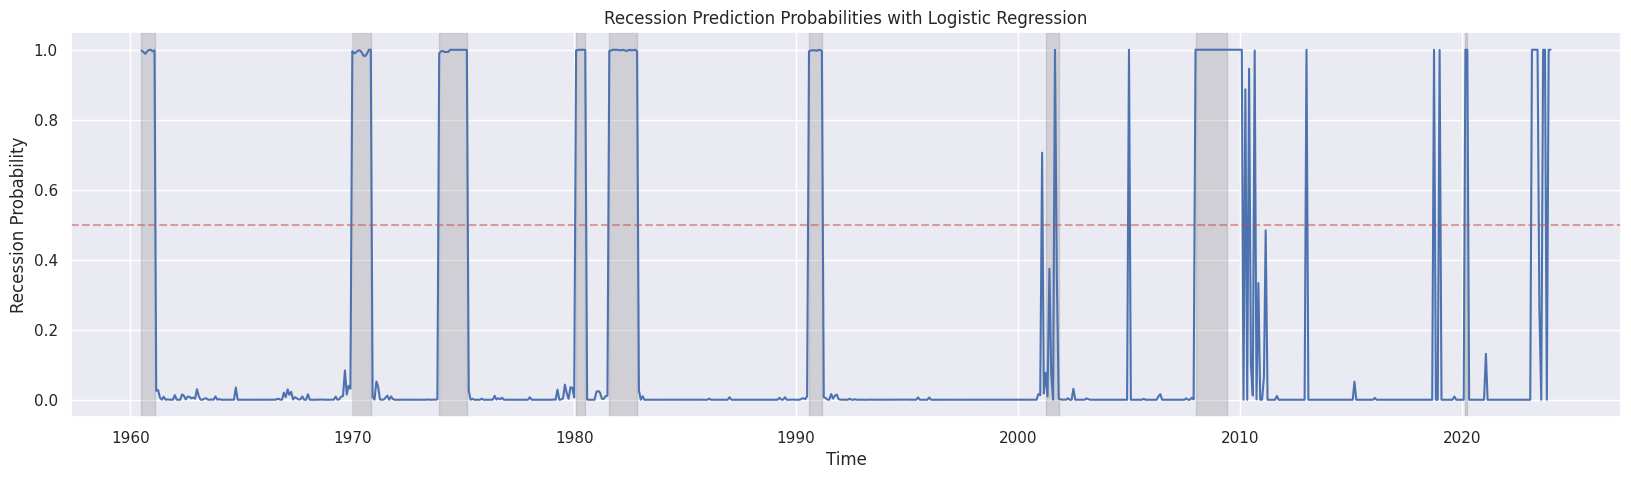

763
763


In [1182]:
# Plot recession probabilities
plot_recession_probabilities(LR, 'Logistic Regression')

In [1183]:
evaluate_model(LR, 'Logistic Regression')

----------------- Training set: Logistic Regression --------------------
[[409   0]
 [  0  65]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       409
         1.0       1.00      1.00      1.00        65

    accuracy                           1.00       474
   macro avg       1.00      1.00      1.00       474
weighted avg       1.00      1.00      1.00       474

----------------- Test set: Logistic Regression ------------------------
[[237  24]
 [  7  21]]
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       261
         1.0       0.47      0.75      0.58        28

    accuracy                           0.89       289
   macro avg       0.72      0.83      0.76       289
weighted avg       0.92      0.89      0.90       289



In [1184]:
data[data['id'].str.contains('UNRATE')] #CUU: Consumer Price Index

,id,title,realtime_start,realtime_end,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity
440,UNRATE,Unemployment Rate,2/4/2024,2/4/2024,1/1/1948,1/1/2024,Monthly,M,Percent,%,Seasonally Adjusted,SA,2024-02-02 07:49:02-06:00,95
441,UNRATENSA,Unemployment Rate,2/4/2024,2/4/2024,1/1/1948,1/1/2024,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2024-02-02 07:49:06-06:00,55


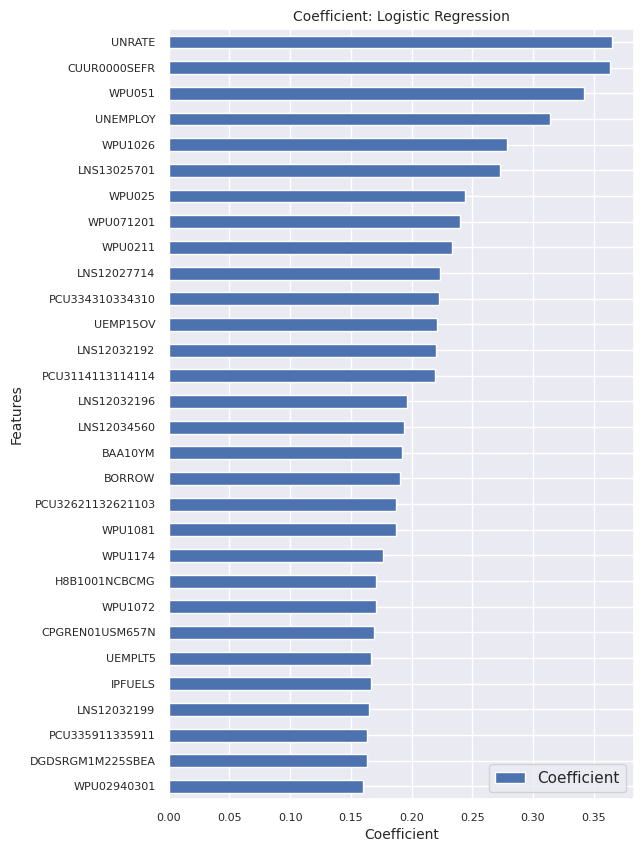

In [1185]:
plot_feature_importance(LR, 'Logistic Regression', num_features=30);

In [1186]:
# Check indicator name - Input ID to see indicator names
data[data['id'].str.contains('WPU')]

,id,title,realtime_start,realtime_end,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity
486,WPU01,Producer Price Index by Commodity: Farm Products,2/4/2024,2/4/2024,1/1/1913,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:53:08-06:00,30
487,WPU011,Producer Price Index by Commodity: Farm Produc...,2/4/2024,2/4/2024,1/1/1926,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:53:15-06:00,19
488,WPU0111,Producer Price Index by Commodity: Farm Produc...,2/4/2024,2/4/2024,1/1/1947,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:53:23-06:00,4
489,WPU011101,Producer Price Index by Commodity: Farm Produc...,2/4/2024,2/4/2024,1/1/1947,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:53:17-06:00,10
490,WPU01110104,Producer Price Index by Commodity: Farm Produc...,2/4/2024,2/4/2024,1/1/1947,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:53:15-06:00,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,WPUID61113,Producer Price Index by Commodity: Intermediat...,2/4/2024,2/4/2024,1/1/1947,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:51:16-06:00,7
653,WPUID6112,Producer Price Index by Commodity: Intermediat...,2/4/2024,2/4/2024,1/1/1947,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:51:37-06:00,5
654,WPUID612,Producer Price Index by Commodity: Intermediat...,2/4/2024,2/4/2024,1/1/1947,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:51:14-06:00,12
655,WPUID62,Producer Price Index by Commodity: Intermediat...,2/4/2024,2/4/2024,1/1/1947,12/1/2023,Monthly,M,Index 1982=100,Index 1982=100,Not Seasonally Adjusted,NSA,2024-01-12 07:51:03-06:00,56


## Random Forest

In [1187]:
# Random Forest

# Create and fit RandomForestClassifier model
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

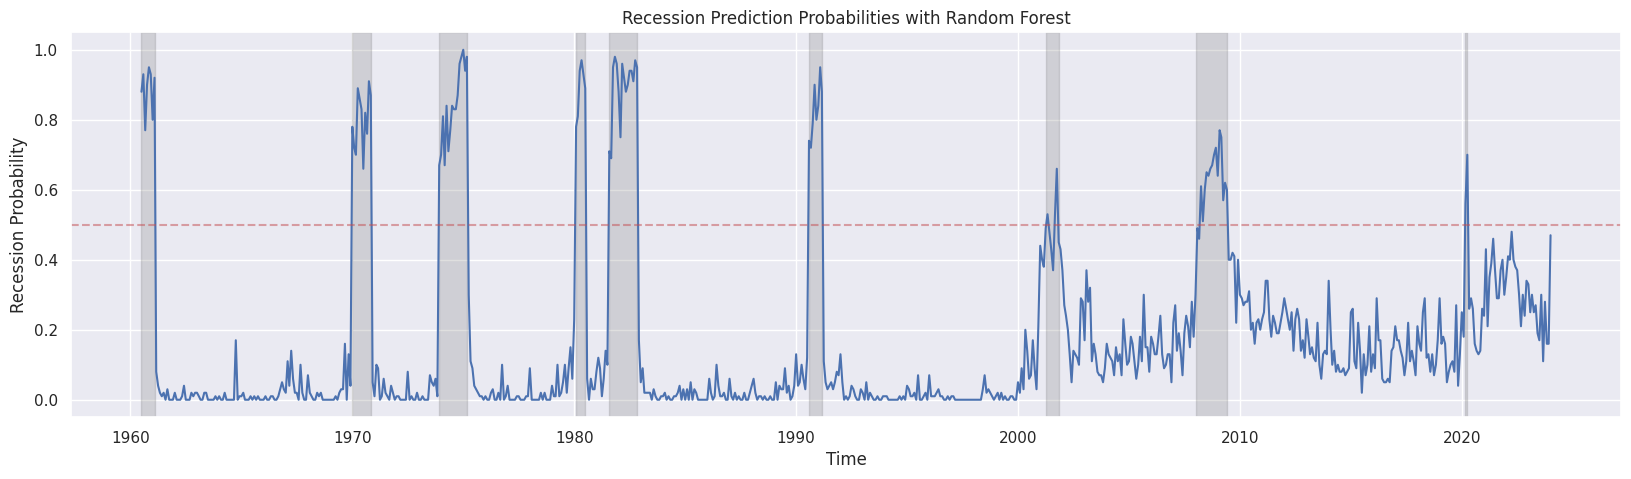

763
763


In [1188]:
plot_recession_probabilities(RF, 'Random Forest');

In [1189]:
evaluate_model(RF, 'Random Forest')

----------------- Training set: Random Forest --------------------
[[409   0]
 [  0  65]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       409
         1.0       1.00      1.00      1.00        65

    accuracy                           1.00       474
   macro avg       1.00      1.00      1.00       474
weighted avg       1.00      1.00      1.00       474

----------------- Test set: Random Forest ------------------------
[[261   0]
 [  8  20]]
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       261
         1.0       1.00      0.71      0.83        28

    accuracy                           0.97       289
   macro avg       0.99      0.86      0.91       289
weighted avg       0.97      0.97      0.97       289



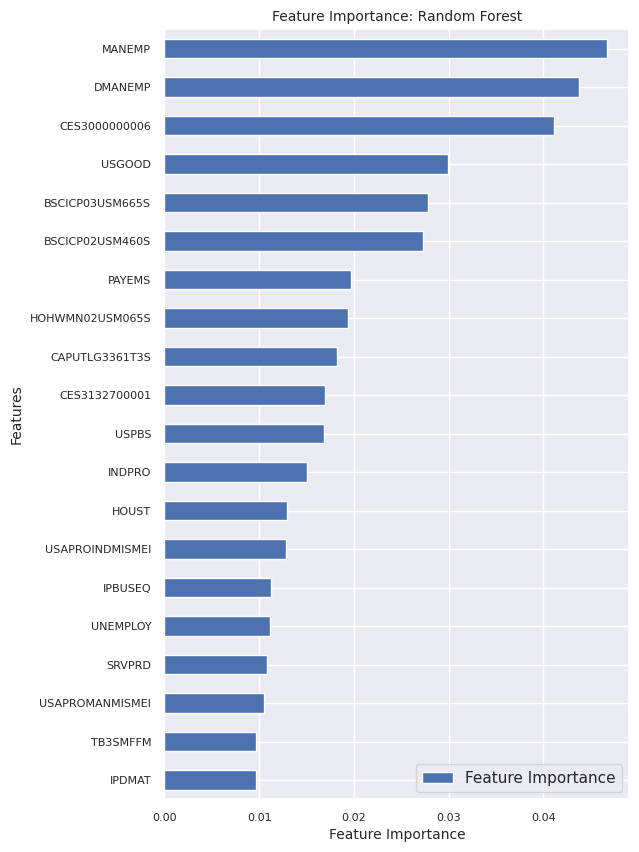

In [1190]:
plot_feature_importance(RF, 'Random Forest', num_features=20);

In [1191]:
# Check indicator name - Input ID to see indicator names
data[data['id'].str.contains('INDPRO')]

,id,title,realtime_start,realtime_end,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity
253,INDPRO,Industrial Production: Total Index,2/4/2024,2/4/2024,1/1/1919,12/1/2023,Monthly,M,Index 2017=100,Index 2017=100,Seasonally Adjusted,SA,2024-01-17 08:28:01-06:00,79


## XGBoost

In [1192]:
# XGBoost

# Create and fit XGBClassifier model with silent mode
XGB = xgb.XGBClassifier(silent=True, random_state=42)
XGB.fit(X_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

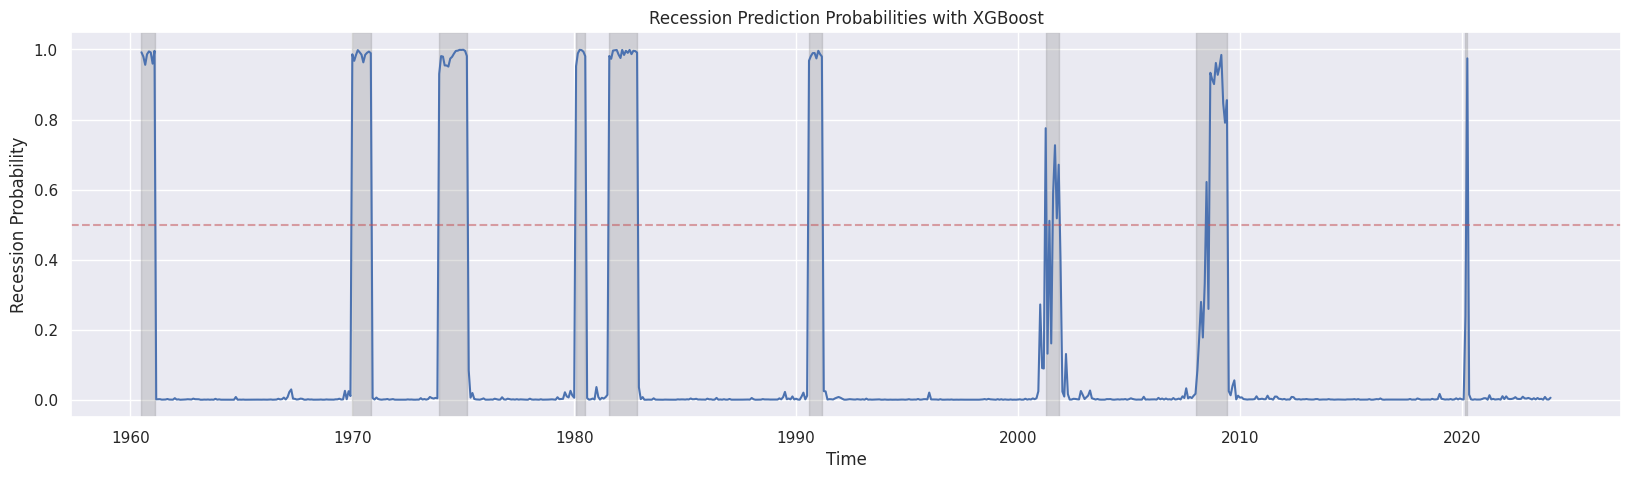

763
763


In [1193]:
plot_recession_probabilities(XGB, 'XGBoost');

In [1194]:
evaluate_model(XGB, 'XGBoost')

----------------- Training set: XGBoost --------------------
[[409   0]
 [  0  65]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       409
         1.0       1.00      1.00      1.00        65

    accuracy                           1.00       474
   macro avg       1.00      1.00      1.00       474
weighted avg       1.00      1.00      1.00       474

----------------- Test set: XGBoost ------------------------
[[261   0]
 [ 10  18]]
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       261
         1.0       1.00      0.64      0.78        28

    accuracy                           0.97       289
   macro avg       0.98      0.82      0.88       289
weighted avg       0.97      0.97      0.96       289



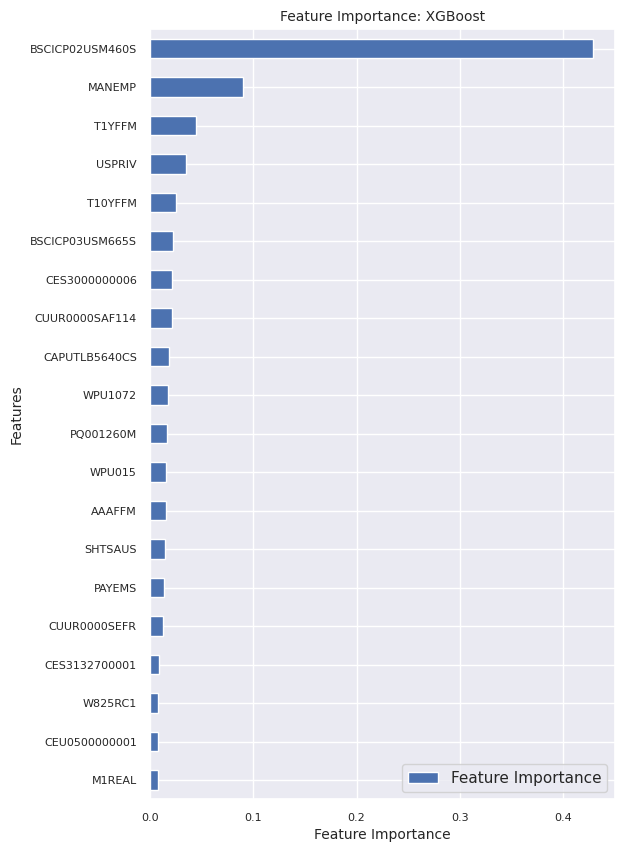

In [1195]:
plot_feature_importance(XGB, 'XGBoost', num_features=20);

In [1196]:
# Check indicator name - Input ID to see indicator names
data[data['id'].str.contains('BSCIC')]

,id,title,realtime_start,realtime_end,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity
31,BSCICP02USM460S,Business Tendency Surveys (Manufacturing): Con...,2/4/2024,2/4/2024,1/1/1960,12/1/2023,Monthly,M,Percent,%,Seasonally Adjusted,SA,2024-01-12 14:13:09-06:00,31
32,BSCICP03USM665S,Business Tendency Surveys (Manufacturing): Con...,2/4/2024,2/4/2024,1/1/1960,11/1/2023,Monthly,M,Normalised (Normal=100),Normalised (Normal=100),Seasonally Adjusted,SA,2023-12-12 14:48:04-06:00,45


# Cross Validation

In [1197]:
# Define models
seed = 42
models = [
    ('LR', LogisticRegression(class_weight='balanced', random_state=seed)),
    ('LR_L1', LogisticRegression(C=selected_alpha, penalty='l1', solver='saga', class_weight='balanced', random_state=seed)),
    ('LR_L2', LogisticRegression(C=selected_alpha, penalty='l2', solver='saga', class_weight='balanced', random_state=seed)),
    ('LDA', LinearDiscriminantAnalysis()),
    ('DT', DecisionTreeClassifier(splitter='best', random_state=seed)),
    ('KNN', KNeighborsClassifier()),
    ('GB', GradientBoostingClassifier(random_state=seed)),
    ('ABC', AdaBoostClassifier(random_state=seed)),
    ('SVC', SVC(class_weight='balanced', probability=True, random_state=seed)),
    ('RF', RandomForestClassifier(random_state=seed)),
    ('XGB', xgb.XGBClassifier(silent=True))
]

LR: 0.944304 (0.058612)
LR_L1: 0.878481 (0.069147)
LR_L2: 0.739241 (0.158627)
LDA: 0.632911 (0.107110)
DT: 0.870886 (0.067648)
KNN: 0.908861 (0.050252)
GB: 0.893671 (0.087186)
ABC: 0.913924 (0.063745)
SVC: 0.918987 (0.077039)
RF: 0.916456 (0.063342)
XGB: 0.924051 (0.085852)


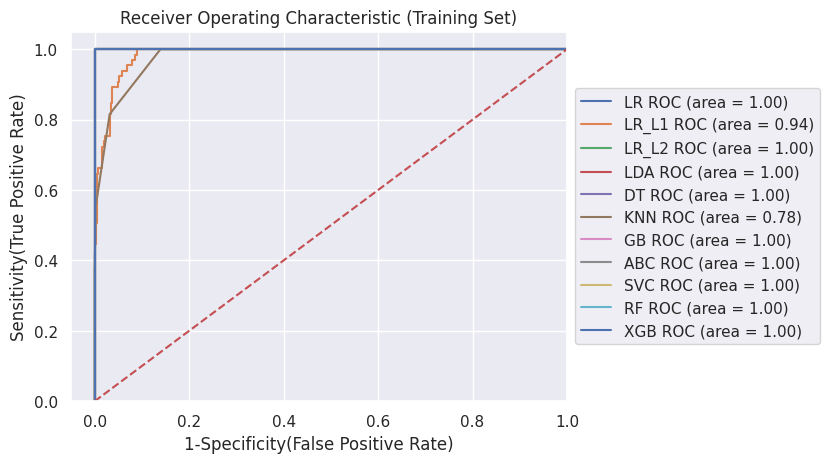

In [1198]:
num_splits = 5
kfold = TimeSeriesSplit(n_splits=num_splits)
scoring = 'roc_auc' # roc-auc may not be appropriate for this case due to class imbalance

# Cross-validation
results = []
names = []
for name, model in models:
  cv_results = cross_val_score(estimator=model, X=X_train_selected, y=y_train, cv=kfold) # use default scoring
  # cv_results = cross_val_score(estimator=model, X=X_train_selected, y=y_train, cv=kfold, scoring=scoring) # use specified scoring
  results.append(cv_results)
  names.append(name)
  model.fit(X_train_selected, y_train)

  fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_selected)[:,1])
  auc = roc_auc_score(y_train, model.predict(X_train_selected))
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))

  cv_metrics = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # simple mean
  # cv_metrics = "%s: %f (%f)" % (name, np.nanmean(cv_results), np.nanstd(cv_results)) # mean without 'nan'
  print(cv_metrics)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Training Set)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

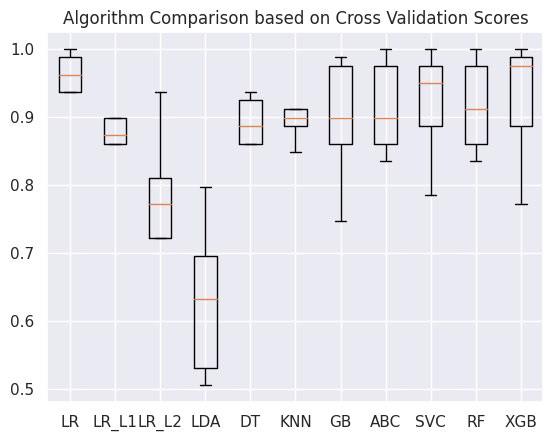

In [1199]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Remove 'nan' from results
filtered_results = [np.array(arr)[~np.isnan(arr)] for arr in results]
plt.boxplot(filtered_results, showfliers=False) # plot without 'nan'
# plt.boxplot(results) # plot without removing 'nan'

ax.set_xticklabels(names)
ax.set_title("Algorithm Comparison based on Cross Validation Scores");